# 00 Import Library

In [ ]:
# !pip install pyemd

     ------------------------------------ 148.7/148.7 kB 402.4 kB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloadi

True

In [1]:
import pandas as pd
import numpy as np
import re
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from deep_translator import GoogleTranslator

# Stopword Removal & Stemming (Bahasa Indonesia)
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import stanza
from wordcloud import WordCloud

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Word Embedding
import gensim
from gensim.models import Word2Vec, FastText
from gensim.utils import simple_preprocess

# Modeling
from scipy import stats
from numpy import dot
from numpy.linalg import norm
from ast import literal_eval
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity

# 01 Load Dataset

In [4]:
df = pd.read_csv('cleaned_jobstreet.csv')
df

,title,category,lemmatization
0,data scientist financial conglomerates supervi...,analysis reporting banking financial services,"['role', 'purpose', 'execute', 'suptech', 'dat..."
1,data scientist,mathematics statistics information sciences sc...,"['job', 'description', 'responsibility', 'data..."
2,data annotator,database development administration informatio...,"['job', 'description', 'key', 'responsibility'..."
3,data scientist artificial intelligence,mathematics statistics information sciences sc...,"['join', 'dcap', 'dynamic', 'fastgrowing', 'te..."
4,data scientist,mathematics statistics information sciences sc...,"['key', 'responsibility', 'data', 'exploration..."
...,...,...,...
475,data scientist,mathematics statistics information sciences sc...,"['job', 'description', 'work', 'closely', 'int..."
476,data scientist pricing,businesssystems analysts information communica...,"['people', 'job', 'description', 'data', 'scie..."
477,data analyst,mathematics statistics information sciences sc...,"['duty', 'responsibility', 'collect', 'clean',..."
478,data analyst pricing staff,analysis reporting manufacturing transport log...,"['key', 'responsibility', 'collect', 'process'..."


In [5]:
df = df.drop_duplicates(subset=["title", "category", "lemmatization"]).reset_index(drop=True)
df

,title,category,lemmatization
0,data scientist financial conglomerates supervi...,analysis reporting banking financial services,"['role', 'purpose', 'execute', 'suptech', 'dat..."
1,data scientist,mathematics statistics information sciences sc...,"['job', 'description', 'responsibility', 'data..."
2,data annotator,database development administration informatio...,"['job', 'description', 'key', 'responsibility'..."
3,data scientist artificial intelligence,mathematics statistics information sciences sc...,"['join', 'dcap', 'dynamic', 'fastgrowing', 'te..."
4,data scientist,mathematics statistics information sciences sc...,"['key', 'responsibility', 'data', 'exploration..."
...,...,...,...
281,data engineering leader,engineering software information communication...,"['responsibility', 'define', 'lead', 'data', '..."
282,data engineer azure data factory,engineering software information communication...,"['responsibility', 'develop', 'manage', 'data'..."
283,lead data engineer,mathematics statistics information sciences sc...,"['team', 'grabfin', 'empower', 'people', 'sout..."
284,assistant software engineer intern paid intern...,engineering software information communication...,"['position', 'join', 'team', 'hithink', 'techn..."


In [6]:
df.rename(columns={
    "lemmatization": "tokens_cleaned"
}, inplace=True)
all_sentences = df["tokens_cleaned"].tolist()

# 02 Text Vectorization

## a. Word2Vec

In [25]:
w2v_model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=2, workers=4)

def sentence_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df["w2v_vec"] = df["tokens_cleaned"].apply(lambda x: sentence_vector(x, w2v_model))


In [26]:
df["w2v_vec"].head(10)

0    [-0.06771691, 0.15504594, 0.037991486, 0.13723...
1    [-0.08119085, 0.1645948, 0.029374449, 0.133933...
2    [-0.07371248, 0.139598, 0.024557043, 0.1353948...
3    [-0.083504334, 0.15742616, 0.031319316, 0.1333...
4    [-0.07843771, 0.15671341, 0.032834865, 0.12668...
5    [-0.06789328, 0.15558015, 0.033636034, 0.14339...
6    [-0.08430881, 0.1582437, 0.036246974, 0.149093...
7    [-0.07507844, 0.15327312, 0.02708749, 0.128869...
8    [-0.08593858, 0.16472518, 0.024023239, 0.13944...
9    [-0.075347185, 0.16119486, 0.036197014, 0.1357...
Name: w2v_vec, dtype: object

## b. FastText

In [23]:
ft_model = FastText(sentences=all_sentences, vector_size=100, window=5, min_count=2, workers=4)

df["ft_vec"] = df["tokens_cleaned"].apply(lambda x: sentence_vector(x, ft_model))

In [24]:
df["ft_vec"].head(10)

0    [-0.033464678, 0.045669176, -0.12430112, 0.319...
1    [-0.04324713, 0.060142573, -0.12528236, 0.3361...
2    [-0.030604156, 0.03242655, -0.12814106, 0.3065...
3    [-0.0387006, 0.05643551, -0.1312352, 0.3391503...
4    [-0.03672259, 0.05381471, -0.13287745, 0.33249...
5    [-0.028306924, 0.04200538, -0.13518678, 0.3302...
6    [-0.035492238, 0.050054196, -0.12697423, 0.333...
7    [-0.031061454, 0.046267245, -0.12935604, 0.323...
8    [-0.042218562, 0.059303954, -0.1284009, 0.3441...
9    [-0.03875054, 0.052613586, -0.1250085, 0.33109...
Name: ft_vec, dtype: object

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["tokens_cleaned"])

# 03 Labelling & Similarity Mapping

## Cosine Similarity

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

def get_top_k_similar_jobs(embeddings, df, top_k=5):
    sim_matrix = cosine_similarity(np.stack(embeddings))  
    results = []

    for i in range(len(df)):
        sim_scores = list(enumerate(sim_matrix[i]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top_matches = sim_scores[1:top_k+1]  
        matches = [
            {
                "job_title": df.iloc[j]["title"],
                "category": df.iloc[j]["category"],
                "score": score
            }
            for j, score in top_matches
        ]
        results.append({
            "job": df.iloc[i]["title"],
            "category": df.iloc[i]["category"],
            "matches": matches
        })
    return results


## WMD Similarity

In [28]:
from gensim.similarities import WmdSimilarity

wmd_index_w2v = WmdSimilarity(all_sentences, w2v_model.wv, num_best=5)

results_wmd_w2v = []
for idx, query in enumerate(all_sentences):
    matches = wmd_index_w2v[query]
    top_matches = [{"job_title": df.iloc[j]["title"], 
                    "category": df.iloc[j]["category"], 
                    "score": round(1 / (d + 1e-9), 4)}  
                   for j, d in matches if j != idx]
    results_wmd_w2v.append({
        "job": df.iloc[idx]["title"],
        "category": df.iloc[idx]["category"],
        "matches": top_matches
    })

In [29]:
wmd_index_ft = WmdSimilarity(all_sentences, ft_model.wv, num_best=5)

results_wmd_ft = []
for idx, query in enumerate(all_sentences):
    matches = wmd_index_ft[query]
    top_matches = [{"job_title": df.iloc[j]["title"], 
                    "category": df.iloc[j]["category"], 
                    "score": round(1 / (d + 1e-9), 4)}  
                   for j, d in matches if j != idx]
    results_wmd_ft.append({
        "job": df.iloc[idx]["title"],
        "category": df.iloc[idx]["category"],
        "matches": top_matches
    })

# 04 Recommendation Modeling

### a. Cosine + W2Vec

In [30]:
topk_w2v = get_top_k_similar_jobs(df["w2v_vec"], df, top_k=5)

for result in topk_w2v:
    print(f"Job: {result['job']}")
    print(f"Category: {result['category']}")
    for match in result['matches']:
        print(f" - {match['job_title']:<50} | Score: {match['score']:.4f}")
    print()

Job: data scientist financial conglomerates supervision
Category: analysis reporting banking financial services
 - data scientist project intern trust and safetymonetization integritydata | Score: 0.9997
 - data analyst data scientist nus office of data and intelligence | Score: 0.9997
 - data analyst                                       | Score: 0.9997
 - data scientist                                     | Score: 0.9996
 - data analyst                                       | Score: 0.9996

Job: data scientist
Category: mathematics statistics information sciences science technology
 - data analyst                                       | Score: 0.9997
 - senior data engineer                               | Score: 0.9996
 - artificial intelligence engineer                   | Score: 0.9996
 - data engineer                                      | Score: 0.9996
 - assistant manager data analyst up to               | Score: 0.9995

Job: data annotator
Category: database development adminis

### b. Cosine + FastText

In [31]:
topk_ft = get_top_k_similar_jobs(df["ft_vec"], df, top_k=5)

for result in topk_ft:
    print(f"Job: {result['job']}")
    print(f"Category: {result['category']}")
    for match in result['matches']:
        print(f" - {match['job_title']:<50} | Score: {match['score']:.4f}")
    print()

Job: data scientist financial conglomerates supervision
Category: analysis reporting banking financial services
 - data analyst data scientist nus office of data and intelligence | Score: 0.9997
 - data scientist project intern trust and safetymonetization integritydata | Score: 0.9997
 - data analyst                                       | Score: 0.9995
 - data scientist                                     | Score: 0.9995
 - data analyst                                       | Score: 0.9995

Job: data scientist
Category: mathematics statistics information sciences science technology
 - artificial intelligence engineer                   | Score: 0.9996
 - assistant software engineer intern paid internship | Score: 0.9995
 - data engineer                                      | Score: 0.9995
 - data engineer                                      | Score: 0.9994
 - data analyst                                       | Score: 0.9994

Job: data annotator
Category: database development adminis

### c. WMD + W2Vec

In [32]:
def print_results(results, method="WMD+Model"):
    for res in results:
        print(f"[{method}] Job: {res['job']}")
        print(f"Category: {res['category']}")
        for match in res['matches']:
            print(f" - {match['job_title']:<50} | Score: {match['score']:.4f}")
        print()

print_results(results_wmd_w2v, method="WMD + Word2Vec")

[WMD + Word2Vec] Job: data scientist financial conglomerates supervision
Category: analysis reporting banking financial services
 - data analyst data scientist nus office of data and intelligence | Score: 1.0327
 - data scientist project intern trust and safetymonetization integritydata | Score: 1.0366
 - data analyst                                       | Score: 1.0367
 - data analyst                                       | Score: 1.0395

[WMD + Word2Vec] Job: data scientist
Category: mathematics statistics information sciences science technology
 - data analyst                                       | Score: 1.0353
 - data engineer financial services                   | Score: 1.0360
 - data analyst                                       | Score: 1.0385
 - data engineer                                      | Score: 1.0396

[WMD + Word2Vec] Job: data annotator
Category: database development administration information communication technology
 - data engineering leader                  

### d. WMD + FastText

In [33]:
def print_results(results, method="WMD+Model"):
    for res in results:
        print(f"[{method}] Job: {res['job']}")
        print(f"Category: {res['category']}")
        for match in res['matches']:
            print(f" - {match['job_title']:<50} | Score: {match['score']:.4f}")
        print()

print_results(results_wmd_ft, method="WMD + FastText")

[WMD + FastText] Job: data scientist financial conglomerates supervision
Category: analysis reporting banking financial services
 - data analyst data scientist nus office of data and intelligence | Score: 1.0341
 - data scientist project intern trust and safetymonetization integritydata | Score: 1.0367
 - data analyst                                       | Score: 1.0369
 - data analyst                                       | Score: 1.0394

[WMD + FastText] Job: data scientist
Category: mathematics statistics information sciences science technology
 - data analyst                                       | Score: 1.0357
 - data engineer financial services                   | Score: 1.0364
 - data engineer                                      | Score: 1.0390
 - data analyst                                       | Score: 1.0390

[WMD + FastText] Job: data annotator
Category: database development administration information communication technology
 - data engineering leader                  

              Method  Average Similarity Score
0  Cosine + Word2Vec                    0.9993
1  Cosine + FastText                    0.9992
2     WMD + Word2Vec                    1.0452
3     WMD + FastText                    1.0452


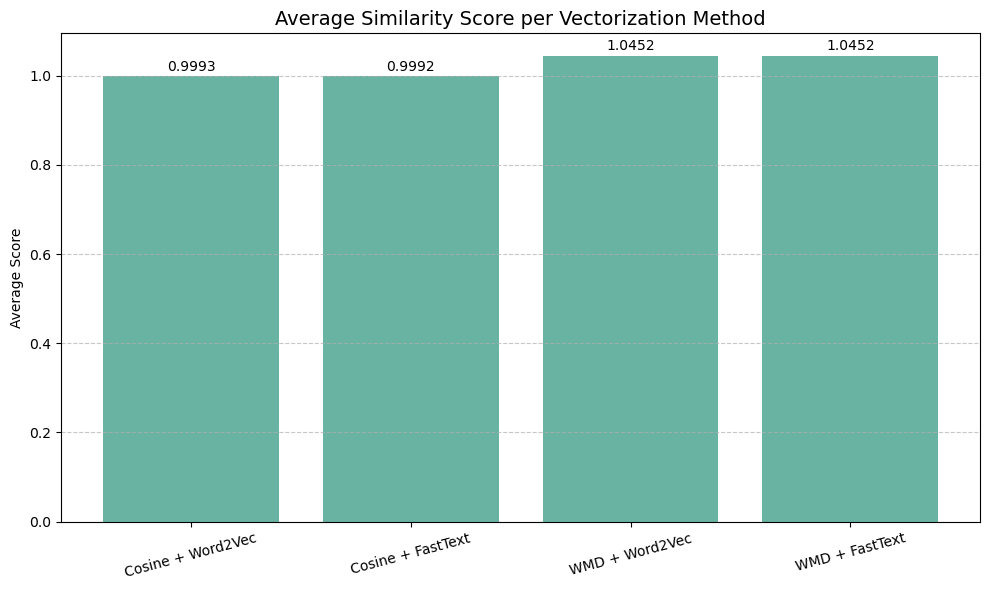

In [34]:
def average_score(results):
    all_scores = []
    for res in results:
        scores = [match['score'] for match in res['matches']]
        all_scores.extend(scores)
    return round(np.mean(all_scores), 4)

comparison_df = pd.DataFrame({
    "Method": ["Cosine + Word2Vec", "Cosine + FastText", "WMD + Word2Vec", "WMD + FastText"],
    "Average Similarity Score": [
        average_score(topk_w2v),
        average_score(topk_ft),
        average_score(results_wmd_w2v),
        average_score(results_wmd_ft)
    ]
})
print(comparison_df)

# bar chart comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df["Method"], comparison_df["Average Similarity Score"], color="#69b3a2")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.4f}", ha='center', va='bottom', fontsize=10)

plt.title("Average Similarity Score per Vectorization Method", fontsize=14)
plt.ylabel("Average Score")
plt.ylim(0, max(comparison_df["Average Similarity Score"]) + 0.05)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
